#### Installing dependencies

In [1]:
!pip install numpy torch matplotlib

     |████████████████████████████████| 748.9MB 56kB/s  eta 0:00:018   |█▏                              | 26.8MB 129kB/s eta 1:33:00     |██                              | 46.1MB 689kB/s eta 0:16:59     |██                              | 46.4MB 641kB/s eta 0:18:16     |███                             | 70.6MB 534kB/s eta 0:21:09     |███▉                            | 90.7MB 291kB/s eta 0:37:41     |████▊                           | 110.9MB 784kB/s eta 0:13:34     |█████▌                          | 128.0MB 1.0MB/s eta 0:09:56     |██████▋                         | 153.9MB 447kB/s eta 0:22:10     |████████                        | 186.6MB 496kB/s eta 0:18:53     |████████                        | 186.8MB 496kB/s eta 0:18:52     |████████▏                       | 191.8MB 296kB/s eta 0:31:22     |██████████                      | 234.0MB 312kB/s eta 0:27:26     |██████████▏                     | 238.3MB 239kB/s eta 0:35:29     |███████████▋                    | 273.0MB 227kB/s eta 0:34:55 

#### Importing packages

In [2]:
%matplotlib inline
import numpy as np
import torch
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import OrderedDict
from math import pi

#### NN class for Regression

In [3]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize, nhiddenLayers, hiddenNeurons):
        super(linearRegression, self).__init__()
        layers = []

        for i in range(0,nhiddenLayers): # adding hidden layers
            if(i==0): #Input layer
                layers.append(torch.nn.Linear(inputSize, hiddenNeurons))
                layers.append(torch.nn.ReLU())
            else:
                layers.append(torch.nn.BatchNorm1d(hiddenNeurons))
                layers.append(torch.nn.Linear(hiddenNeurons, hiddenNeurons))
                layers.append(torch.nn.ReLU())

        layers.append(torch.nn.Linear(hiddenNeurons, outputSize)) # output layer
        self.model = torch.nn.Sequential(*layers)
        #print("\nNetwork Architecture: \n", self.model,"\n")

    def forward(self, x):
        out = self.model(x)
        return out

#### NN Parameters

In [4]:
learningRate = 0.001
momentum = 0.9 
epochs = 2000 # Original Value is 2000
batch_size = 3000
train_set = 60000
test_set = 60000

#### Making the Dataset

In [5]:
f1 = lambda x: 2 * (x ** 2) - 1
func = lambda x: f1(f1(np.cos(x)))
x = torch.unsqueeze(torch.FloatTensor(train_set+test_set).uniform_(-2*pi, 2*pi), dim=1)
y = func(x)

# Train Dataset and making generator for mini-batches
train_x = x[0:train_set]
train_y = y[0:train_set]
train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Test Dataset
test_x = x[train_set:(train_set+test_set)]
test_y = y[train_set:(train_set+test_set)]

#### Function to obtain training and testing results for a specific network architecture

In [6]:
def trainTestNet(arch:tuple, log:bool = False) -> torch.tensor:
    
    # Defining network architecture
    net = linearRegression(1, 1, arch[0], arch[1]) # Defining network architecture where arch[1] corresponds to the layer number and arch[2] to the number of units in a hidden layer
    criterion = torch.nn.MSELoss() # Define criterion to evaluate the network, in this case MSE
    optimizer = torch.optim.SGD(net.parameters(), lr=learningRate, momentum=momentum) # optimizer used is SGD
    parameters = sum(p.numel() for p in net.parameters()) # Number of parameter for this specific architecture
    # Training the network
    if(log):
        print("Hidden Layers Quantity: ",arch[0],",  Units per Layer: ",arch[1],"\n")
        print("Training Results: ")
    for epoch in range(1,epochs+1): # Iteration in each epoch
        for step, (t_x, t_y) in enumerate(train_loader): # Iterating in each mini-batch
            optimizer.zero_grad() # Removing buffer from previous epochs
            outputs = net(t_x) # Output training into the model
            loss = criterion(outputs, t_y) # Get loss for predicted outputs
            if((epoch%100==0) and step == train_set/batch_size-1): #Print Train results for each 100 epochs
                if(log):
                    print("Epoch: ", epoch,"  Step: ", step,"  Loss: ", loss)
            loss.backward() # Propagate the loss
            optimizer.step() # Update parameters
            
    # Evaluating the network using the test dataset
    test_outputs = net(test_x) # Generating network outputs for test data
    mean_test_error = torch.sqrt(criterion(test_outputs, test_y)) # Calculating RMSE over the predicted data
    if(log):
        print("\n\nEvaluation over test dataset:")
        print("Test Error (RMSE): ", mean_test_error, "\n\n\n\n")
    
    return (mean_test_error, parameters)

#### Defining network architectures deployment

In [7]:
net_archs = np.array([[1,24], [1,48], [1,72], [1,128], [1,256], [2, 12], [2,24], [2,36], [3,8], [3,16], [3,24]]) # The first value of a tuple corresponds to the number of hidden layers and the other value to number of units/layer
times = 2 # Repeating each architecture result N times
results = torch.zeros([len(net_archs), times])
arch_parameters = torch.zeros([len(net_archs)])

#### Running Experiments

In [8]:
for t in range(times): # Repeating the process N times
    for index, arch in enumerate(net_archs): # Iterating over all architectures
        print("Time: ", t, "  Arch: ", arch)
        (results[index, t], arch_parameters[index]) = trainTestNet(arch)
        

Time:  0   Arch:  [ 1 24]
Time:  0   Arch:  [ 1 48]
Time:  0   Arch:  [ 1 72]
Time:  0   Arch:  [  1 128]
Time:  0   Arch:  [  1 256]
Time:  0   Arch:  [ 2 12]
Time:  0   Arch:  [ 2 24]
Time:  0   Arch:  [ 2 36]
Time:  0   Arch:  [3 8]
Time:  0   Arch:  [ 3 16]
Time:  0   Arch:  [ 3 24]
Time:  1   Arch:  [ 1 24]
Time:  1   Arch:  [ 1 48]
Time:  1   Arch:  [ 1 72]
Time:  1   Arch:  [  1 128]
Time:  1   Arch:  [  1 256]
Time:  1   Arch:  [ 2 12]
Time:  1   Arch:  [ 2 24]
Time:  1   Arch:  [ 2 36]
Time:  1   Arch:  [3 8]
Time:  1   Arch:  [ 3 16]
Time:  1   Arch:  [ 3 24]


#### Plotting Results

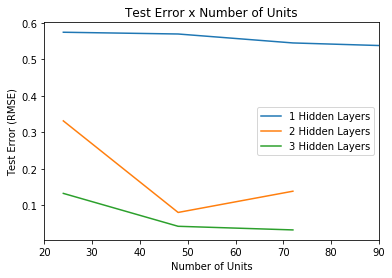

In [9]:
# Test Error x Number of Units Graph
plt.figure()
layers_number = np.unique(net_archs[:,0])
min_results = torch.min(results, 1)
for i in range(len(layers_number)): plt.plot(layers_number[i]*net_archs[net_archs[:,0]==layers_number[i],1], min_results[0][net_archs[:,0]==layers_number[i]].detach().numpy(), label="{} Hidden Layers".format(layers_number[i]))
plt.title("Test Error x Number of Units")
plt.xlabel("Number of Units")
plt.ylabel("Test Error (RMSE)")
plt.legend()
plt.xlim([20, 90])
plt.show()

In [10]:
print(arch_parameters[net_archs[:,0]==layers_number[i]])

tensor([ 201.,  657., 1369.])


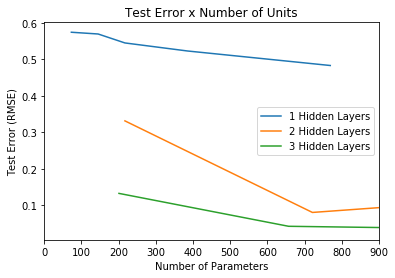

In [11]:
# Test Error x Number of Parameters Graph
plt.figure()
layers_number = np.unique(net_archs[:,0])
min_results = torch.min(results, 1)
for i in range(len(layers_number)): plt.plot(arch_parameters[net_archs[:,0]==layers_number[i]], min_results[0][net_archs[:,0]==layers_number[i]].detach().numpy(), label="{} Hidden Layers".format(layers_number[i]))
plt.title("Test Error x Number of Units")
plt.xlabel("Number of Parameters")
plt.ylabel("Test Error (RMSE)")
plt.legend()
plt.xlim([0, 900])
plt.show()